In [1]:
import sys
import numpy as np
from scipy.ndimage import find_objects, label
import glob
import tensorflow as tf
from tqdm import tqdm
import cv2
from PIL import Image, ImageColor, ImageFilter, ImageDraw
import xml.etree.ElementTree as ET
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications.densenet import DenseNet121


# Classes for the custom decoders
# table decoder
class table_decoder(tf.keras.layers.Layer):
    '''
        This is the custom layer defined for the table decoder following the above architecture.
    '''
    def __init__(self):
        super().__init__()
        # defining the layers
        self.conv7 = Conv2D(filters=128, kernel_size=(1,1), kernel_regularizer=regularizers.l2(0.001))
        self.upsamp_pool4 = UpSampling2D(size=(2,2), interpolation='bilinear')
        self.upsamp_pool3 = UpSampling2D(size=(2,2), interpolation='bilinear')
        self.upsamp_out = Conv2DTranspose(filters=2, kernel_size=(3,3), strides=2, padding='same', activation='softmax')
        
    def call(self, inp, pool3, pool4):
        # passing through convolution
        x = self.conv7(inp)
        # upsampling and concatenating with pool4
        x = self.upsamp_pool4(x)
        x = Concatenate()([x, pool4])
        
        # upsampling and concatenating with pool3
        x = self.upsamp_pool3(x)
        x = Concatenate()([x, pool3])
        
        # further upsampling and output
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)
        fin = self.upsamp_out(x)
        
        return fin


# column decoder
class col_decoder(tf.keras.layers.Layer):
    '''
        This custom layer is defined for the Column deocder following the above column decoder architecture. 
    '''
    def __init__(self):
        super().__init__()
        # defining the layers
        self.conv7 = Conv2D(filters=128, kernel_size=(1,1), kernel_regularizer=regularizers.l2(0.001), activation='relu')
        self.drop = Dropout(rate=0.8)
        self.conv8 = Conv2D(filters=128, kernel_size=(1,1), kernel_regularizer=regularizers.l2(0.001))
        self.upsamp_pool4 = UpSampling2D((2,2), interpolation='bilinear')
        self.upsamp_pool3 = UpSampling2D((2,2), interpolation='bilinear')
        self.upsamp_out = Conv2DTranspose(filters=2, kernel_size=(3,3), strides=2, padding='same', activation='softmax')
        
    def call(self, inp, pool3, pool4):
        # passing through convolutions
        x = self.conv7(inp)
        x = self.drop(x)
        x = self.conv8(x)
        
        # upsampling and concatenating encoder pool outputs
        x = self.upsamp_pool4(x)
        x = Concatenate()([x, pool4])
        x = self.upsamp_pool3(x)
        x = Concatenate()([x, pool3])
        
        # final upsampling and outputs
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)
        fin = self.upsamp_out(x)
        
        return fin


# making the model archtecture
def ModelConstructor():
    '''
        This function makes the tablenet architecture and returns the model object after loading the trained weights.
    '''
    tf.keras.backend.clear_session()
    # making the encoder architecture
    tf.keras.backend.clear_session()
    model_input = Input(shape=(1024,1024,3))
    encoder = DenseNet121(include_top=False, weights='imagenet', input_tensor=model_input)

    # for pool3 and pool4, we are going to use the outputs of the following layers
    # pool4 = pool4_relu
    # pool3 = pool3_relu
    pool3 = encoder.get_layer('pool3_relu').output
    pool4 = encoder.get_layer('pool4_relu').output

    # making all the layers of the encoder untrainable
    for layer in encoder.layers:
        layer.trainable = False

    # continuing the model architecture
    # convolution layers
    conv_6 = Conv2D(filters=512, kernel_size=(1,1), activation='relu', name='block6_conv1',
                    kernel_regularizer=regularizers.l2(0.001))(encoder.output)
    conv6_drop = Dropout(0.2)(conv_6) # this is the dropping probability and in the paper the keep_prop seems to be 0.8.

    conv_7 = Conv2D(filters=256, kernel_size=(1,1), activation='relu', name='block6_conv2',
                    kernel_regularizer=regularizers.l2(0.001))(conv6_drop)
    conv7_drop = Dropout(0.2)(conv_7) # this is the dropping probability and in the paper the keep_prop seems to be 0.8.
    # decoders
    table_mask = table_decoder()
    column_mask = col_decoder()

    table_out = table_mask(conv7_drop, pool3, pool4)
    column_out = column_mask(conv7_drop, pool3, pool4)

    # declaring the model

    tablenet = Model(inputs=model_input, outputs=[table_out, column_out])

    # loading the weights
    tablenet.load_weights('DenseNet-Tablenet.h5')

    return tablenet


# HELPER FUNCTIONS
def decode_image(uploader):
    '''
        This functions takes the uploader object and extracts the image out of it
        and then decodes the image into a numpy array to be used for the model.
        Note: This function does not check if the image is uploaded or not, thus, 
        a manual check is required for checking if the uploader actually contains an image.
    '''
    # getting the bytes from the uploader
    image_bytes = uploader.getvalue()
    # converting the bytes into a numpy array - https://stackoverflow.com/a/49517948/11881261
    image_decoded = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), -1)[:,:,:3]
    
    return image_decoded


def predict_masks(image, model):
    '''
        This function takes the image tensor, preprocesses it and predicts the table and column masks from the image.
    '''
    # preprocessing the image
    # resizing
    im = tf.image.resize(image, size=[1024,1024])
    im = tf.cast(im, dtype=tf.float32)/255

    # making a batch
    im = tf.expand_dims(im, axis=0)

    # making prediction using the model
    table_mask, col_mask = model.predict(im)

    return (im, table_mask, col_mask)


def get_mask_image(mask_pred):
    '''
        This function gets the predicted mask image from the masks predicted by the model
    '''
    # taking argmax from both the channels
    mask_pred = tf.argmax(mask_pred, axis=-1)
    # adding a channel axis
    mask_pred = mask_pred[..., tf.newaxis][0]
    
    return mask_pred


def filter_table(image, table_mask):
    '''
        This function turns the image from a matrix to actual image and then uses the table mask to filter out the table from the image.
    '''
    # converting image and mask from matrices to images
    im = tf.keras.preprocessing.image.array_to_img(image)
    mask = tf.keras.preprocessing.image.array_to_img(table_mask)
    # st.text()
    # converting mask to greyscale
    mask = mask.convert('L')

    # changing the alpha values of the image using the table mask
    im.putalpha(mask)
    
    return im


def image_reader(image_fname):
    im = Image.open(image_fname).convert("RGB")
    return np.array(im)



2022-05-23 23:28:45.496847: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [150]:
class F1Score:
    def __init__(self, IoU_thresh=0.5, area_thresh=1000):
        self.true_positive = 0
        self.false_positive = 0
        self.truth_count = 0
        self._iou_thresh = IoU_thresh
        self._area_thresh = area_thresh
        self._iou_total = 0
        self._iou_count = 0
    
    def update_state(self, n_truth, IoUs, areas=None):
        if areas is not None:
            IoUs = [i for (i, a) in zip(IoUs, areas) if a > self._area_thresh]
        self._iou_total += sum(IoUs)
        self._iou_count += len(IoUs)
        n_tp = sum(1 for i in IoUs if i >= self._iou_thresh)
        n_fp = len(IoUs) - n_tp
        self.true_positive += n_tp
        self.false_positive += n_fp
        self.truth_count += n_truth
    
    @property
    def precision(self):
        return self.true_positive / max(1, self.true_positive + self.false_positive)
    
    @property
    def recall(self):
        return self.true_positive / max(1, self.truth_count)
    
    @property
    def f1(self):
        return (2 * self.precision * self.recall) / max(1, self.precision + self.recall)
    
    @property
    def iou(self):
        return self._iou_total / max(1, self._iou_count)

In [3]:
def read_sample(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []
    for object_ in root.iter('object'):
        ymin, xmin, ymax, xmax = None, None, None, None
        for box in object_.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)

        bbox = [xmin, ymin, xmax, ymax] # PASCAL VOC
        bboxes.append(bbox)
    im_file = root.find("filename").text
    return im_file, bboxes

In [4]:
tablenet = ModelConstructor()

2022-05-23 23:28:47.951565: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-23 23:28:47.953104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-23 23:28:48.584540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 23:28:48.584987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-05-23 23:28:48.585009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-23 23:28:48.586714: I tensorflow/stream_executor/platform/defau

In [5]:

data_path = "/home/shiki/hdd/WikiTableExtraction/detection"
test_files = list()
with open(f"{data_path}/test_filelist.txt") as fp:
    for line in fp:
        test_files.append(line.strip())

In [12]:
import matplotlib.pyplot as plt

In [140]:
def post_process_bbox(table_mask, size, hw_thresh=10, area_thresh=500):
    table_mask = tf.squeeze(table_mask, axis=-1).numpy()
    page_w, page_h = size
#     print(page_w, page_h)
    resized_w, resized_h = table_mask.shape[:2]
#     print(resized_w, resized_h)
    w_ratio = page_w / resized_w
    h_ratio = page_h / resized_h
    
    labeled, num_feature = label(table_mask)
#     display(Image.fromarray(table_mask.astype('uint8') * 255))
#     print(labeled.shape)
#     plt.imshow(labeled, cmap='nipy_spectral')
#     plt.show()
    slices = find_objects(labeled)
    bboxes = list()
#     print(len(slices), len(slices[0]), num_feature)
    for i, (y_slice, x_slice) in enumerate(slices):
        if np.sum(np.where(labeled == i + 1, 1, 0)) <= area_thresh:
            continue 
        x0 = x_slice.start * w_ratio
        x1 = x_slice.stop * w_ratio
        y0 = y_slice.start * h_ratio
        y1 = y_slice.stop * h_ratio
        if x1 - x0 < hw_thresh or y1 - y0 < hw_thresh:
            continue
        if (x1 - x0) * (y1 - y0) < area_thresh:
            continue
        bboxes.append((int(x0), int(y0), int(x1), int(y1)))
    return bboxes

def post_process_mask(table_mask, size):
    mask = tf.image.resize(table_mask, size)
    mask = tf.squeeze(tf.where(mask > 0.5, True, False), axis=-1)
    return mask.numpy()

In [143]:
def generalized_iou(bbox_true, table_mask, im_h, im_w):
    # compute IoU
    pred_matched = set()
    img_gt = np.zeros_like(table_mask, dtype=bool)
    for tb in bbox_true:
        img_gt[int(tb[1]): int(tb[3]), int(tb[0]): int(tb[2])] = True
        
    I = np.logical_and(table_mask, img_gt)
    U = np.logical_or(table_mask, img_gt)
    return I.sum() / U.sum(), len(bbox_true)
            

In [144]:
def show_example(model, xml_fname):
    print("showing:", xml_fname)
    im_fname, true_bbox = read_sample(f"{data_path}/{xml_fname}")
    im = image_reader(f"{data_path}/images/{im_fname}")
    h, w = im.shape[:2]
    
    image = Image.fromarray(im, mode="RGB").convert("RGBA")
    print(image.size)
    im, table_mask, col_mask = predict_masks(im, tablenet)
    table_mask_img = get_mask_image(table_mask)
    col_mask_img = get_mask_image(col_mask)
    mask_resized = post_process_mask(table_mask_img, (h, w))
    
#     green = ImageColor.getrgb('green')
#     green_im = np.ones([mask_resized.shape[0], mask_resized.shape[1], 3]) * green
#     green_im *= np.expand_dims(mask_resized.astype(int), axis=-1)
#     green_mask = Image.fromarray(green_im, mode='RGB')
#     print(green_mask.size)
#     display(green_mask)
    
    mask_alpha = Image.fromarray((mask_resized * 255).astype('uint8')).convert("L")
    print(mask_alpha.size)
    green_mask = Image.new('RGB', image.size, color='green')
    green_mask.putalpha(mask_alpha)
    display(green_mask)
    mask = Image.new("RGB", green_mask.size, (255, 255, 255))
    mask.paste(green_mask, mask=green_mask.split()[3])
    display(mask)
    
#     image.putalpha(mask_alpha.point(lambda p: max(p, 128)))
    display(image)
    print(image.mode, green_mask.mode)
    bboxes = post_process_bbox(table_mask_img, (w, h))
    draw = ImageDraw.Draw(image)
    for box in bboxes:
        draw.rectangle(box, outline='green', width=2)
    final_im = Image.blend(image, mask.convert("RGBA"), alpha=0.5)
    display(final_im)

In [ ]:
metrics = [(0.5, F1Score(0.5, 100)), (0.75, F1Score(0.75, 100)), (0.95, F1Score(0.95, 100))]
for xml_fname in tqdm(test_files):
    im_fname, true_bbox = read_sample(f"{data_path}/{xml_fname}")
    im = image_reader(f"{data_path}/images/{im_fname}")
    h, w = im.shape[:2]
    
    _, table_mask, col_mask = predict_masks(im, tablenet)
    table_mask_img = get_mask_image(table_mask)
    col_mask_img = get_mask_image(col_mask)
    mask_resized = post_process_mask(table_mask_img, (h, w))
    this_iou, true_count = generalized_iou(true_bbox, mask_resized, w, h)
    for _, metric in metrics:
        metric.update_state(1, [this_iou])
    
    
    image = Image.fromarray(im, mode="RGB").convert("RGBA")
    mask_alpha = Image.fromarray((mask_resized * 255).astype('uint8')).convert("L")
    green_mask = Image.new('RGB', image.size, color='green')
    green_mask.putalpha(mask_alpha)
    mask = Image.new("RGB", green_mask.size, (255, 255, 255))
    mask.paste(green_mask, mask=green_mask.split()[3])
    bboxes = post_process_bbox(table_mask_img, (w, h))
    draw = ImageDraw.Draw(image)
    for box in bboxes:
        draw.rectangle(box, outline='green', width=5)
    final_im = Image.blend(image, mask.convert("RGBA"), alpha=0.5)
    final_im.save(f"output_vis/{im_fname}")

  6%|███████▋                                                                                                                                 | 215/3809 [10:32<2:15:00,  2.25s/it]

In [ ]:
for thresh, metric in metrics:
    print(metric.precision, metric.recall, metric.f1, metric.iou)

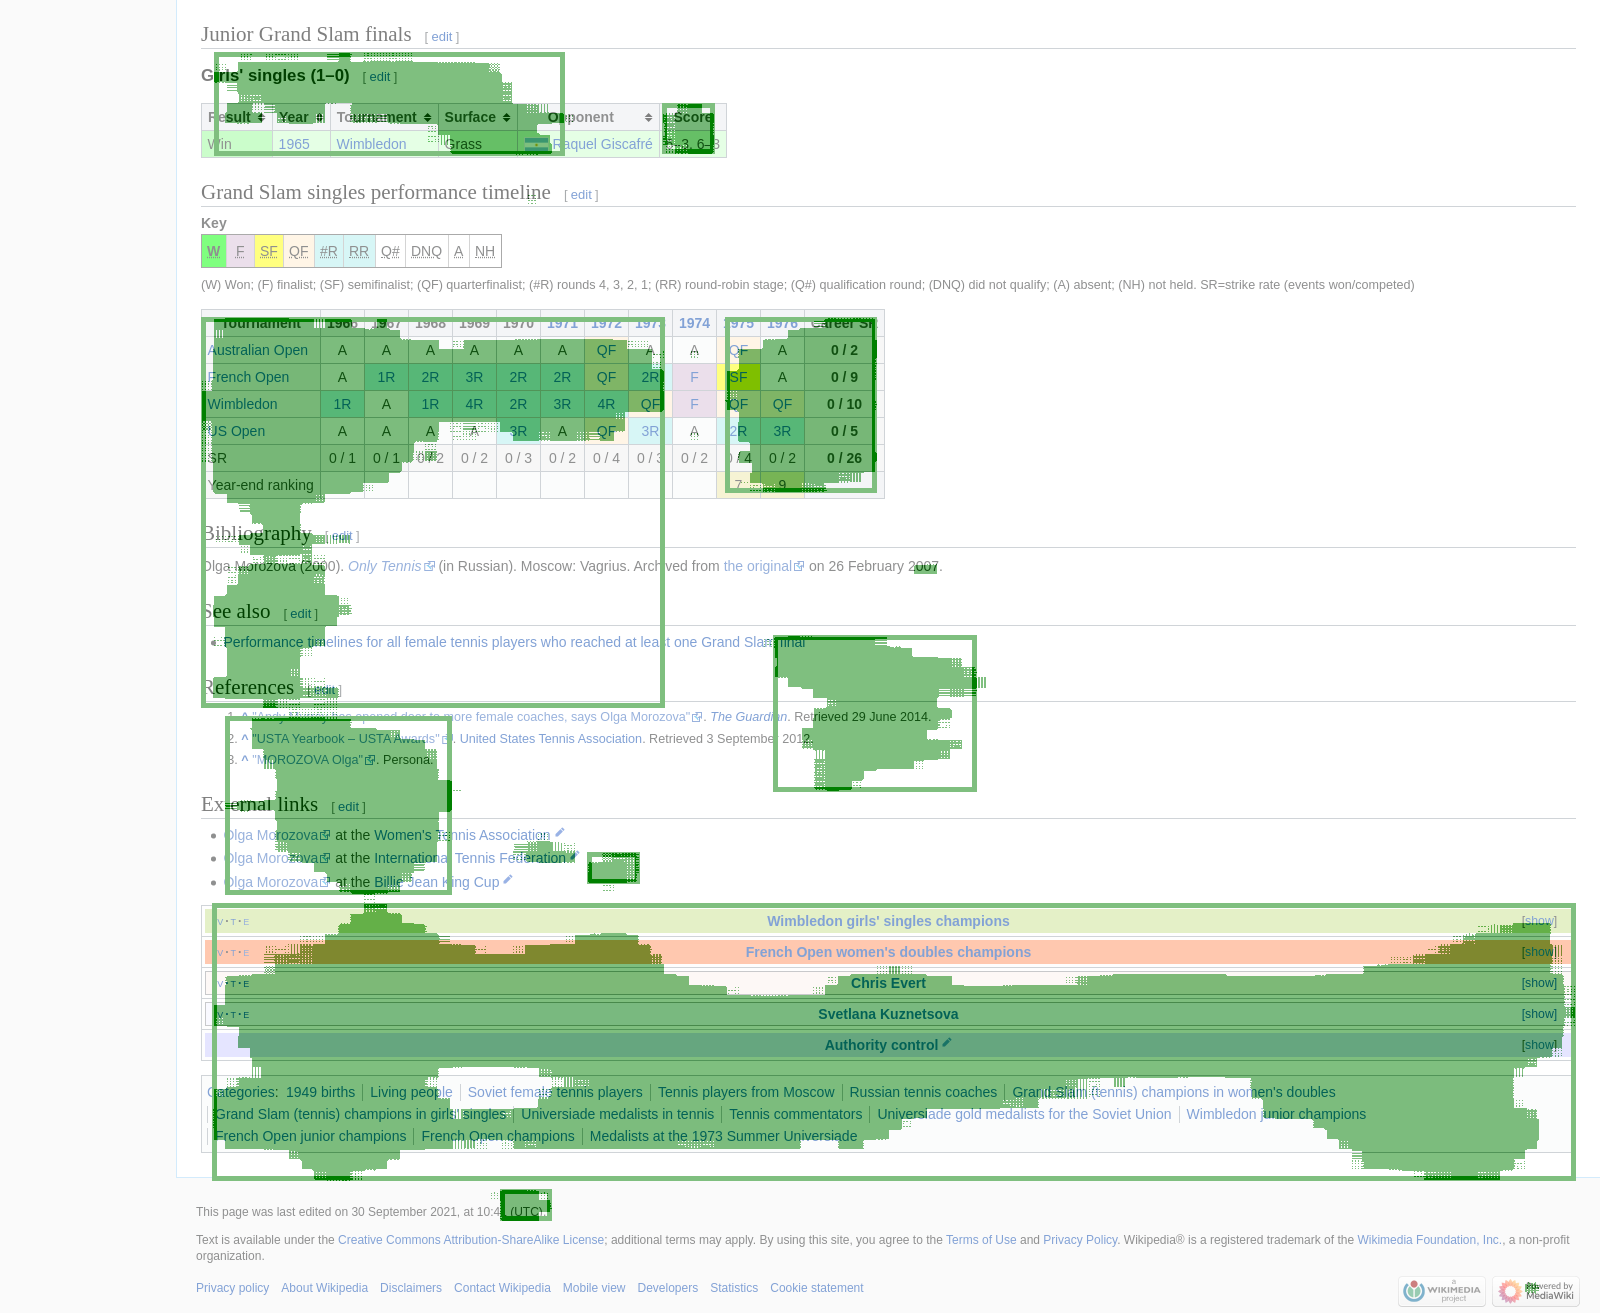

In [152]:
display(Image.open('output_vis/1028380_page_seg_3.png'))
# show_example(tablenet, np.random.choice(test_files))